In [1]:
box = 'Box_n50_0_1400'
# box = 'Box69_1400'
param_names = ['d0','d1', 
               'e0','e1', 
               'f0', 'f1', 
               'g0', 'g1']
ndim = len(param_names)

In [2]:
from aemulusnu_massfunction.massfunction_fitting_tinker import *
from aemulusnu_hmf_lib.utils import *

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [3]:
cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

In [4]:
import pyccl as ccl

cosmo = cosmo_params[box]


h = cosmo['H0']/100
Ωb =  cosmo['ombh2'] / h**2
Ωc =  cosmo['omch2'] / h**2

ccl_cosmo = ccl.Cosmology(Omega_c=Ωc,
                      Omega_b=Ωb,
                      h=h,
                      A_s=cosmo['10^9 As']*10**(-9),
                      n_s=cosmo['ns'],
                      w0=cosmo['w0'],
                      m_nu=[cosmo['nu_mass_ev']/3, cosmo['nu_mass_ev']/3, cosmo['nu_mass_ev']/3])

In [5]:
ccl_cosmo['m_nu']

[0.023570226666666666, 0.023570226666666666, 0.023570226666666666]

In [6]:
h = cosmo['H0']/100

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

In [7]:
N_data = {}
M_data = {}
aux_data = {}


vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(NvMs):
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]

100%|██████████| 15/15 [00:00<00:00, 35285.79it/s]


In [8]:
a_list = list(NvMs.keys())
print(a_list)
from scipy.stats import poisson


M_numerics = np.logspace(np.log10(100*Mpart), 16, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

print(jackknife.keys())

[0.302679, 0.366459, 0.403224, 0.488191, 0.512095, 0.537169, 0.563471, 0.591061, 0.620002, 0.65036, 0.715608, 0.787402, 0.866399, 0.953321, 1.0]
dict_keys([0.302679, 0.366459, 0.403224, 0.488191, 0.512095, 0.537169, 0.563471, 0.591061, 0.620002, 0.65036, 0.715608, 0.787402, 0.866399, 0.953321, 1.0])


In [9]:
jack_covs = {a:jackknife[a][1] for a in N_data}

# Inverse of the weighted covariance matrix
inv_weighted_cov = {a:np.linalg.inv(jack_covs[a]) for a in jack_covs}  

scale_cov = {a:np.log(np.linalg.det(jack_covs[a])) for a in jack_covs}

In [10]:
# def p(p0, p1, a):
#     return p0 + (a-0.5)*p1


# class MassFuncAemulusNu_fitting_all_snapshot(MassFunc):
#     """
#     """
#     name = 'AemulusNu'

#     def __init__(self, *,
#                  mass_def="200m",
#                  mass_def_strict=True):
#         super().__init__(mass_def=mass_def, mass_def_strict=mass_def_strict)

#     def _check_mass_def_strict(self, mass_def):
#         return mass_def.Delta == "200m"

#     def _setup(self):
#         self.params = {'d0':-1, 'd1':-1,
#                        'e0':-1, 'e1':-1,
#                        'f0':-1, 'f1':-1,
#                        'g0':-1, 'g1':-1}

#     def set_params(self, params):
#         self.params = dict(zip(self.params.keys(), params))
#         self.paired_params = list(zip(params, params[1:]))[::2]

#     def _get_fsigma(self, cosmo, sigM, a, lnM):
#         scale_params = dict(zip(['d','e','f','g'],[p(p0, p1, a) for p0, p1 in self.paired_params]))
#         return f_G(a, np.exp(lnM), sigM, **scale_params)


In [11]:
mass_function = MassFuncAemulusNu_fitting_all_snapshot()
mass_function.set_params([0.5, 0, 
                          1.12,0,
                          2.3, 0, 
                          1.3, 0])
mass_function(ccl_cosmo, M_numerics/h, 1.0)*vol/(h**3 * M_numerics * np.log(10))

array([3.96724393e-07, 2.92049647e-07, 2.14842272e-07, 1.57918984e-07,
       1.15972346e-07, 8.50803895e-08, 6.23447374e-08, 4.56247953e-08,
       3.33398654e-08, 2.43224178e-08, 1.77108354e-08, 1.28695474e-08,
       9.32967331e-09, 6.74562209e-09, 4.86287732e-09, 3.49400456e-09,
       2.50112309e-09, 1.78291806e-09, 1.26500213e-09, 8.92823100e-10,
       6.26436182e-10, 4.36631763e-10, 3.02084406e-10, 2.07262285e-10,
       1.40879492e-10, 9.47566070e-11, 6.29855554e-11, 4.13148768e-11,
       2.66986251e-11, 1.69659903e-11, 1.05795219e-11, 6.45828001e-12,
       3.84912867e-12, 2.23294408e-12, 1.25649932e-12, 6.83146737e-13,
       3.57273823e-13, 1.78824708e-13, 8.51710227e-14, 3.83481100e-14,
       1.62006301e-14, 6.36710883e-15, 2.30530190e-15, 7.60367702e-16,
       2.25556626e-16, 5.92958664e-17, 1.35823528e-17, 2.65842890e-18,
       4.34696072e-19, 5.78551007e-20])

In [12]:
def uniform_log_prior(param_values):
    #uniform priorb
    paired_params = list(zip(param_values, param_values[1:]))[::2]
    
    fit_individ_result = [2.11383152, 1., 0.52542576, 1.23987508]
    for i, (p0, p1) in enumerate(paired_params):
        for a in a_list:
            param = p(p0, p1, a)
            if(param < 0):# or param > 5):
                return -np.inf
        frac_diff_from_old = np.abs(p(p0,p1,1)-fit_individ_result[i])/fit_individ_result[i]
        if(frac_diff_from_old > 1e-1):
#             print(frac_diff_from_old, i)
            return -np.inf
    
    
    
    return 0

In [13]:
print(list(map(scaleToRedshift,a_list)))

[2.3038301302700224, 1.7288182306888356, 1.4800111104497748, 1.0483786059144884, 0.9527626709887815, 0.8616115226306804, 0.7747142266416549, 0.691872750866662, 0.6128980229096033, 0.5376099391106464, 0.3974131088528914, 0.26999931420037027, 0.15420262488760939, 0.04896461947234987, 0.0]


In [14]:
from scipy.integrate import quad

def log_likelihood(param_values):   
    """
    Calculates the likelihood of the given tinker parameters 
    
    Args:
        param_values (np.ndarray): Input array of shape (number of params).
        
    Returns:
        float: Resulting log probability
    """

    if(uniform_log_prior(param_values) == -np.inf):
        return -np.inf

    params = dict(zip(param_names, param_values))

    tinker_fs = {}
    model_vals = {}

    
    mass_function.set_params(param_values)
    
    for a_fit in a_list:
        f_tinker_eval = lambda M:mass_function(ccl_cosmo, M/h, a_fit)*vol/(h**3 * M * np.log(10))
        tinker_fs[a_fit] = f_tinker_eval
        model_vals[a_fit] = np.array([quad(tinker_fs[a_fit], edge_pair[0], edge_pair[1], epsabs=0, epsrel=5e-3)[0]
            for edge_pair in NvMs[a_fit]['edge_pairs']
        ])

    
    residuals = {a: model_vals[a]-N_data[a] for a in model_vals}
    log_probs = [ -0.5 * (len(inv_weighted_cov[a])* np.log(2*np.pi) + 
                          np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]) + 
                          scale_cov[a]) 
                 for a in model_vals]
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)


def log_prob(param_values):
    lp = uniform_log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(param_values)

In [15]:
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/Box69_1400_params.pkl", "rb") as f:
    MLE_params = pickle.load(f)
    curr_params = list(MLE_params.values())
    print(MLE_params.values())


dict_values([2.318876013460089, 0.3457206426143319, 0.9081837995258071, -0.13885114111601377, 0.5278150367402827, 0.24486204756111707, 1.2322279643240253, 8.843588988032056e-05])


In [16]:
guess = [1.97,-0.25,
         1.00, 0.10,
         0.51, 0.15,
         1.23, 0.00] #from tinker08 appendix table 4

guess = [1.9852183986769152, 0.107803008005348, 
         1.1301133461561566, -0.07169880255827801, 
         0.41336508057001076, 0.21872460602301808, 
         1.2334987347174953, 0.08506640185137851]
####TMP for Box69_1400
# guess = [2.078553279599441, -0.3415250335524408, 1.009603913314438, -0.022943724520918404, 0.4702351557691141, 0.17454589058929626, 1.2110915306991286, -0.09171018016215982]
# guess = [ 2.08017823,  0.08961757,  0.96235066,  0.0078051,   0.48458743,  0.16021722,
#   1.19197921, -0.01570342]

guess_dict = dict(zip(param_names, guess))
print(guess_dict)
-log_likelihood(list(guess_dict.values()))

{'d0': 1.9852183986769152, 'd1': 0.107803008005348, 'e0': 1.1301133461561566, 'e1': -0.07169880255827801, 'f0': 0.41336508057001076, 'f1': 0.21872460602301808, 'g0': 1.2334987347174953, 'g1': 0.08506640185137851}


1722.0172678132087

In [17]:
from scipy import optimize as optimize

In [18]:
print('Starting ML Fit')
#Start by sampling with a maximum likelihood approach
from scipy import optimize as optimize
neg_log_posterior = lambda *args: -log_prob(*args)
result = optimize.minimize(neg_log_posterior, guess, 
                           method='Nelder-Mead',
                           options={'maxiter': len(guess)*10000})
result['param_names'] = param_names
print(box)
print(result)
print(result['x'])

Starting ML Fit
Box_n50_0_1400
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1721.992195066647
             x: [ 1.983e+00  9.057e-02  1.131e+00 -7.267e-02  4.132e-01
                  2.183e-01  1.233e+00  8.067e-02]
           nit: 447
          nfev: 709
 final_simplex: (array([[ 1.983e+00,  9.057e-02, ...,  1.233e+00,
                         8.067e-02],
                       [ 1.983e+00,  9.053e-02, ...,  1.233e+00,
                         8.067e-02],
                       ...,
                       [ 1.983e+00,  9.048e-02, ...,  1.233e+00,
                         8.065e-02],
                       [ 1.983e+00,  9.062e-02, ...,  1.233e+00,
                         8.069e-02]]), array([ 1.722e+03,  1.722e+03,  1.722e+03,  1.722e+03,
                        1.722e+03,  1.722e+03,  1.722e+03,  1.722e+03,
                        1.722e+03]))
   param_names: ['d0', 'd1', 'e0', 'e1', 'f0', 'f1', 'g0', 'g1']
[ 1.98337026

In [19]:
print(list(result['x']))

[1.983370264834206, 0.09056853573033218, 1.130523375958075, -0.07267477765961666, 0.4131584451871106, 0.21826873760441753, 1.2329801188397385, 0.08067360954649147]


In [20]:
MLE_params = dict(zip(param_names, result['x']))
print(MLE_params)

{'d0': 1.983370264834206, 'd1': 0.09056853573033218, 'e0': 1.130523375958075, 'e1': -0.07267477765961666, 'f0': 0.4131584451871106, 'f1': 0.21826873760441753, 'g0': 1.2329801188397385, 'g1': 0.08067360954649147}


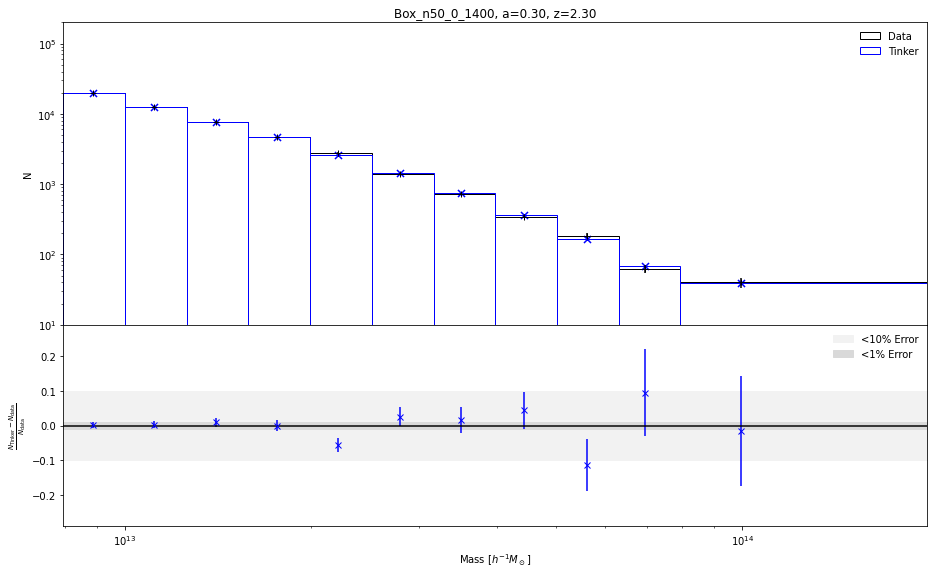

<Figure size 432x288 with 0 Axes>

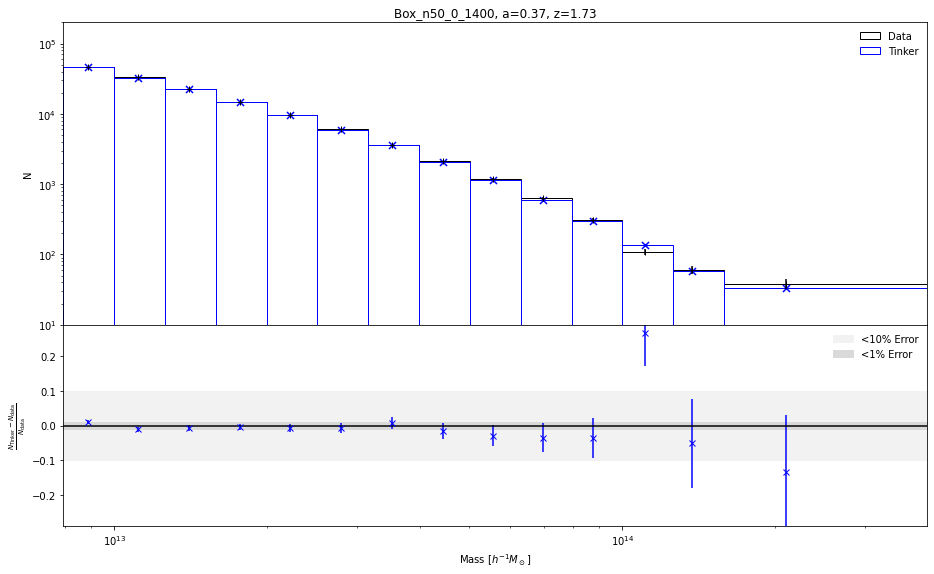

<Figure size 432x288 with 0 Axes>

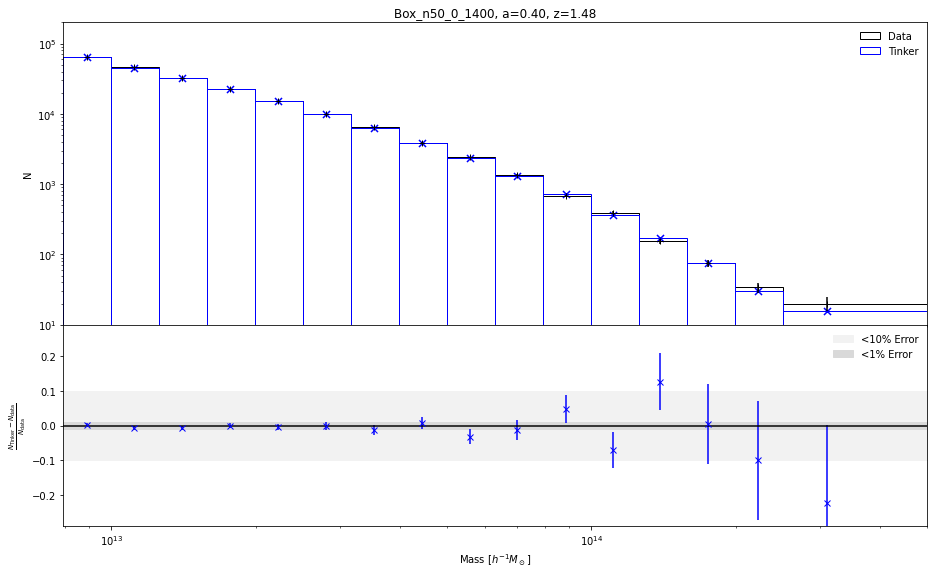

<Figure size 432x288 with 0 Axes>

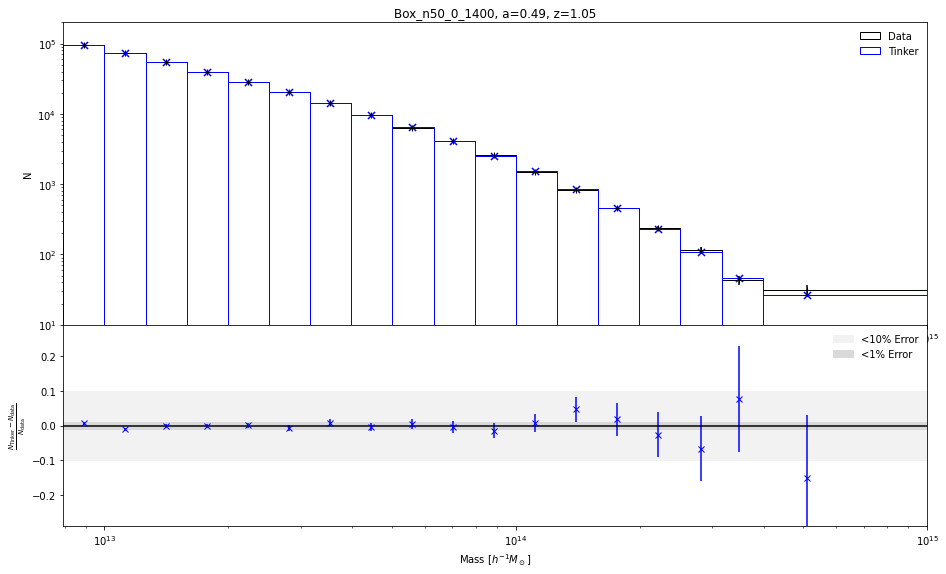

<Figure size 432x288 with 0 Axes>

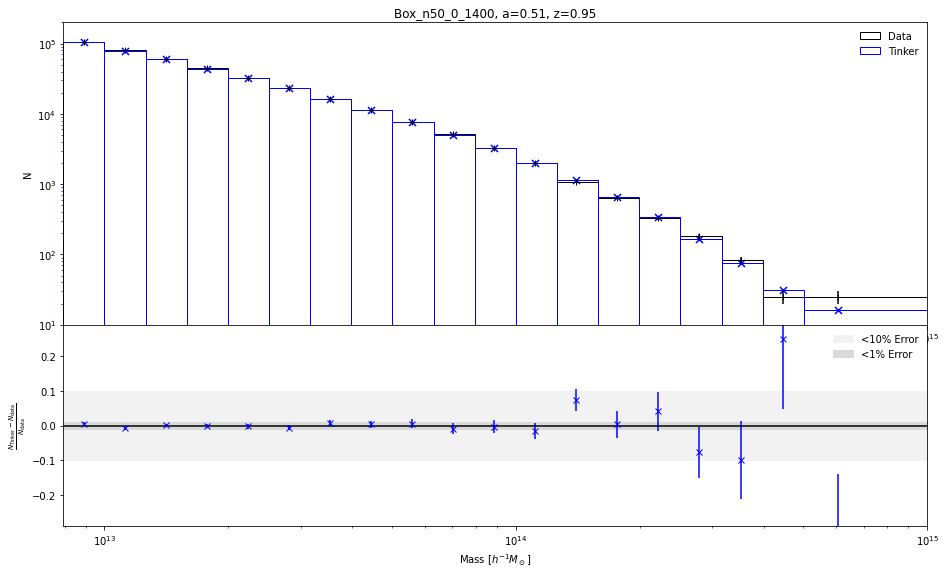

<Figure size 432x288 with 0 Axes>

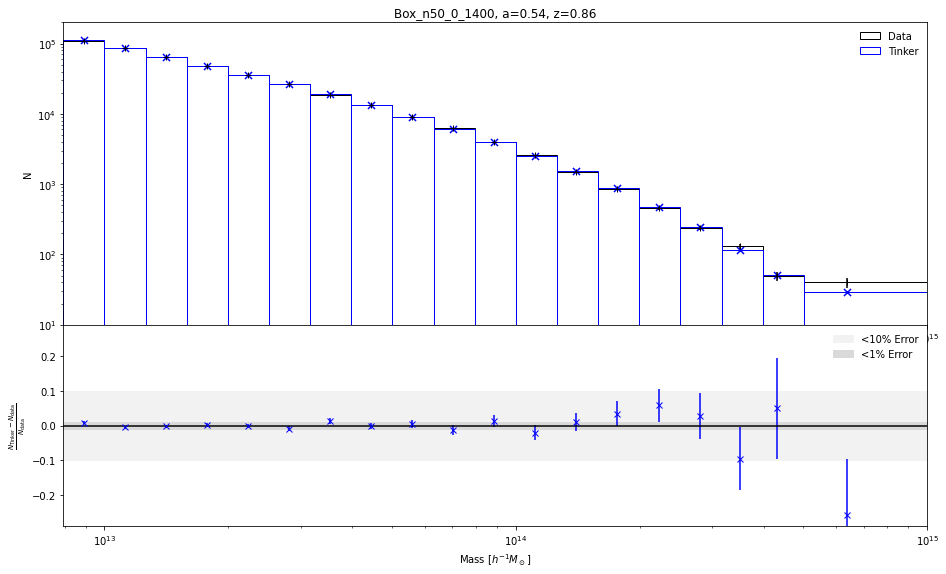

<Figure size 432x288 with 0 Axes>

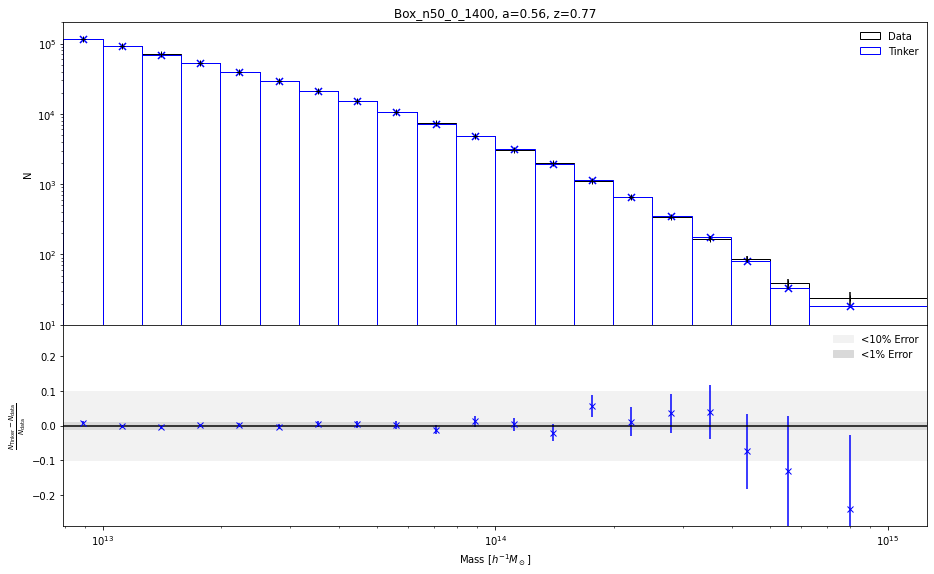

<Figure size 432x288 with 0 Axes>

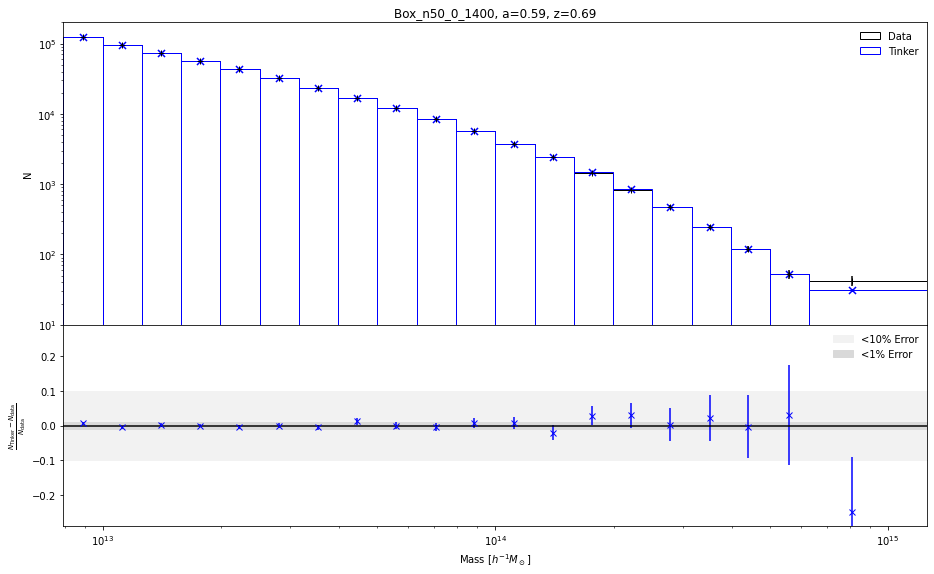

<Figure size 432x288 with 0 Axes>

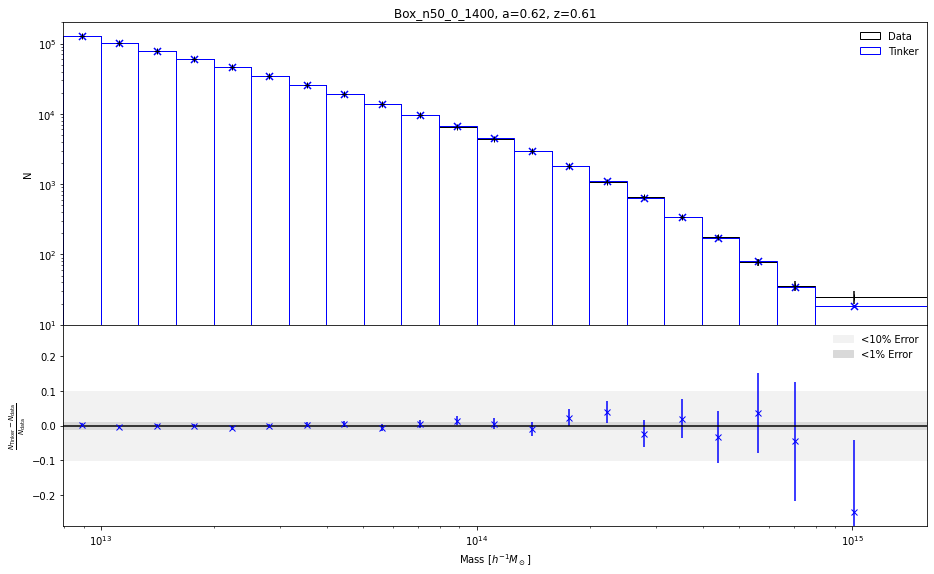

<Figure size 432x288 with 0 Axes>

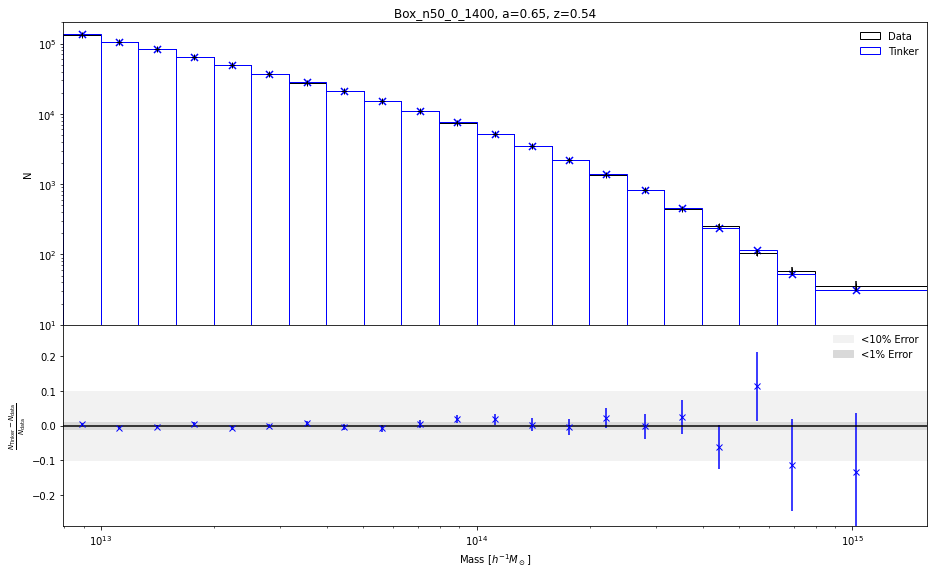

<Figure size 432x288 with 0 Axes>

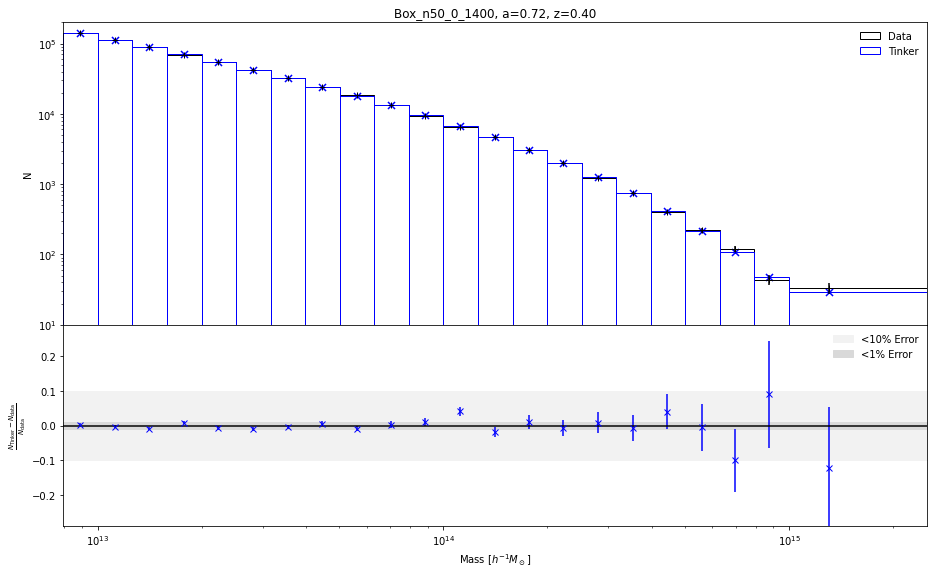

<Figure size 432x288 with 0 Axes>

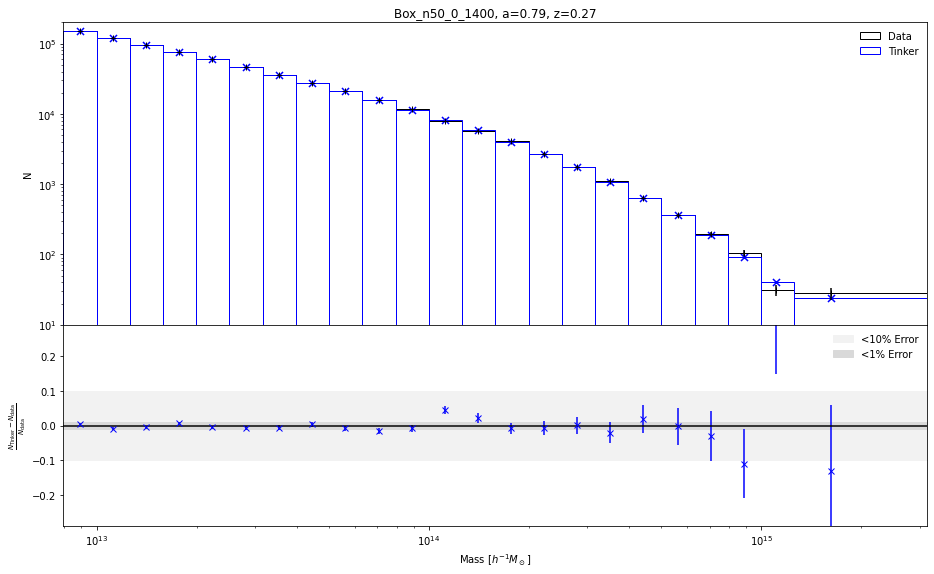

<Figure size 432x288 with 0 Axes>

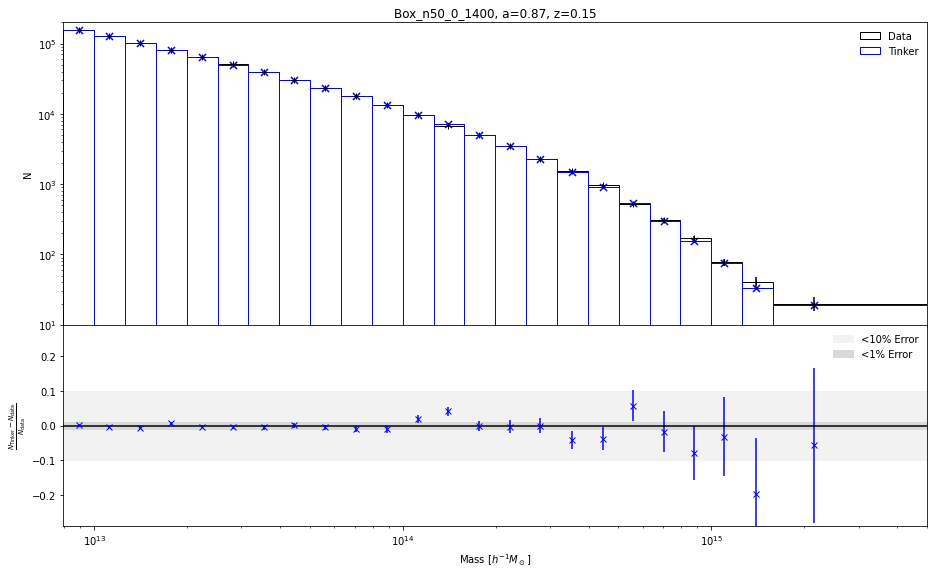

<Figure size 432x288 with 0 Axes>

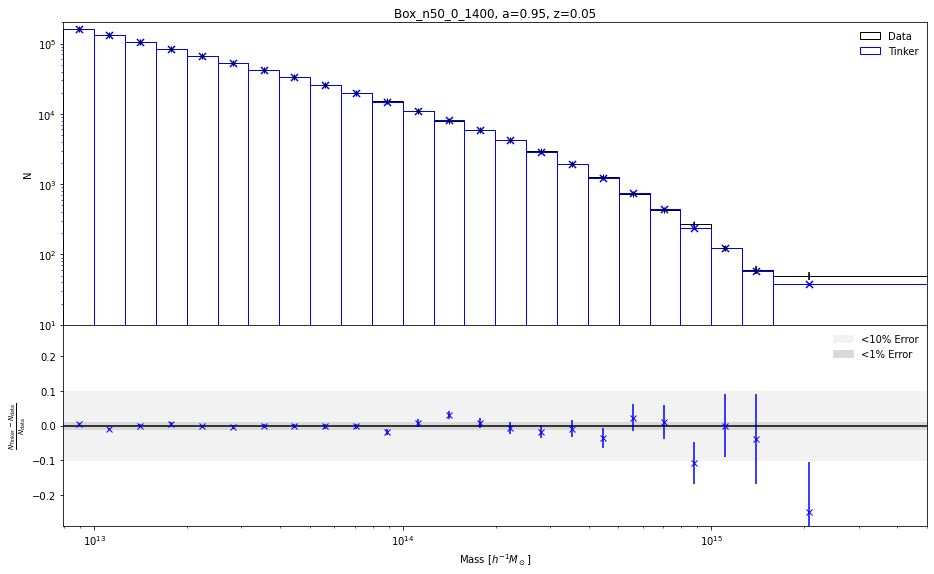

<Figure size 432x288 with 0 Axes>

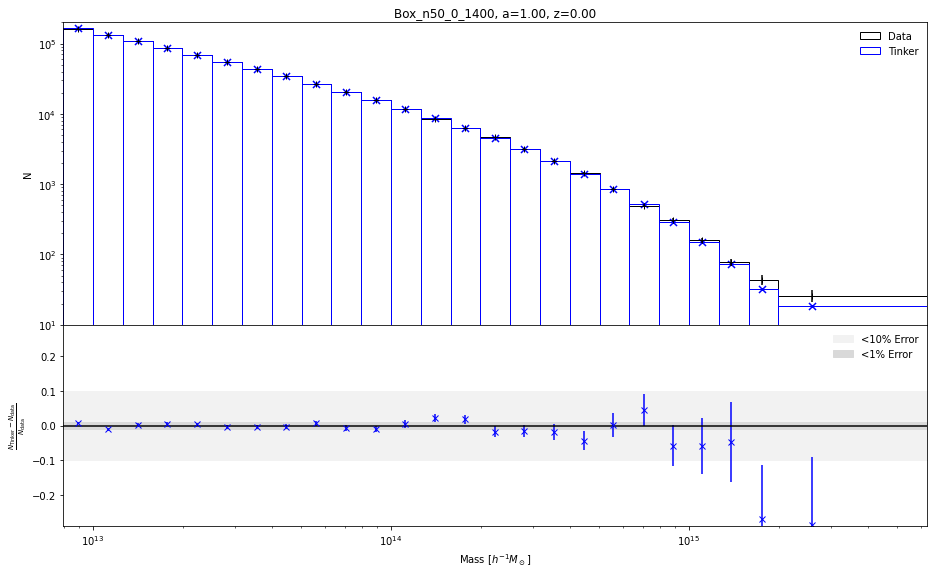

<Figure size 432x288 with 0 Axes>

In [26]:
yerr_dict = {a:np.sqrt(np.diagonal(jack_covs[a])) for a in jack_covs} 
for a in a_list:
    c_params = MLE_params

    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    yerr = yerr_dict[a]

    mass_function.set_params(result['x'])

    f_dNdM =  lambda M:mass_function(ccl_cosmo, M/h, a)*vol/(h**3 * M * np.log(10))

    fit_eval = np.array([quad(f_dNdM, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])

    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMfit_output.pkl"%(box, a), "wb") as f:
        pickle.dump({'Ms':Ms, 'tinker_eval':fit_eval, 'N':N, 'edges':edges}, f)

    axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
    axs[0].scatter(Ms, fit_eval, s=50 , marker='x', c='blue')

    edges = np.array(edges)
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
               align='edge', fill=False, ec='black', label='Data')
    axs[0].bar(x=edges[:-1], height=fit_eval, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker')
    axs[1].errorbar(Ms, (fit_eval-N)/N, yerr/N, fmt='x', color='blue')

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    # axs[1].set_yscale('lin', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))
    axs[0].set_ylim(10, 2e5)
    left = np.ceil(np.log10(200*Mpart) * 10) / 10
    axs[0].set_xlim((10**left, np.max(edges)))
    axs[1].set_xlim((10**left, np.max(edges)))
    axs[1].set_ylim((-.29, .29))
    axs[1].set_yticks([-.2, -.1, 0, .1, .2])
    plt.show()
    plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, a), bbox_inches='tight')

In [22]:
MLE_paried = list(zip(result['x'], result['x'][1:]))[::2]

In [23]:

with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "wb") as f:
    pickle.dump(MLE_params, f)

In [24]:
print(MLE_params)

{'d0': 1.983370264834206, 'd1': 0.09056853573033218, 'e0': 1.130523375958075, 'e1': -0.07267477765961666, 'f0': 0.4131584451871106, 'f1': 0.21826873760441753, 'g0': 1.2329801188397385, 'g1': 0.08067360954649147}


In [25]:
p(MLE_params['d0'], MLE_params['d1'], 1)
print(MLE_params['d0'])

1.983370264834206
